# Adding Different LLM Modalities to Exisiting Agents

### This notebook showcases how to add image generation modality as a conversable agent capability 

We first need to make sure you have the right dependencies installed.
If you are installing autogen from source, run the following command inside the base directory:
- `pip install -e .[llm]`

If you're not installing autogen from source, run the following command:
- `pip install "pyautogen[llm]"`

First lets import all the required modules to run this example

In [1]:
import os
import re
from typing import Dict, Optional

import matplotlib.pyplot as plt
from PIL.Image import Image

import autogen
from autogen.agentchat import groupchat
from autogen.agentchat.contrib import img_utils
from autogen.agentchat.contrib.capabilities import generate_images
from autogen.oai import openai_utils
from IPython.display import display

Let's define our config list with the models we want to experiment with. For this example, we will be using Dalle image generator to interact with the GPT4V agent. 

In [2]:
OAI_CONFIG_LIST = [
    {"model": "dall-e-3", "api_key": os.environ.get("OAI_API_KEY")},
    {"model": "gpt-4-turbo-preview", "api_key": os.environ.get("OAI_API_KEY")},
    {"model": "gpt-4-vision-preview", "api_key": os.environ.get("OAI_API_KEY")},
    {"model": "gpt-3.5-turbo", "api_key": os.environ.get("OAI_API_KEY")},
]

Let's define our LLM configs (you can experiment with different params)

In [3]:
def gpt_config() -> Dict:
    filtered_configs = openai_utils.filter_config(OAI_CONFIG_LIST, filter_dict={"model": ["gpt-4-turbo-preview"]})

    return {"config_list": filtered_configs, "timeout": 120, "temperature": 0.7}


def gpt_v_config() -> Dict:
    filtered_configs = openai_utils.filter_config(OAI_CONFIG_LIST, filter_dict={"model": ["gpt-4-vision-preview"]})

    return {"config_list": filtered_configs, "timeout": 120, "temperature": 0.7, "max_tokens": 1000}


def dalle_config() -> Dict:
    filtered_configs = openai_utils.filter_config(OAI_CONFIG_LIST, filter_dict={"model": ["dall-e-3"]})

    return {"config_list": filtered_configs, "timeout": 120, "temperature": 0.7}

Our system will consist of 2 main agents:
1. Image generator agent
2. Critic agent

The image generator agent will carry a conversation with the critic, and generate images based on the critic's requests.

In [4]:
CRITIC_SYSTEM_MESSAGE = """You need to improve the prompt of the figures you saw.
How to create a figure that is better in terms of color, shape, text (clarity), and other things.
Reply with the following format:

CRITICS: the image needs to improve...
PROMPT: here is the updated prompt!
"""

In [5]:
def critic_agent() -> autogen.ConversableAgent:
    return autogen.ConversableAgent(
        name="critic",
        llm_config=gpt_v_config(),
        system_message=CRITIC_SYSTEM_MESSAGE,
        max_consecutive_auto_reply=3,
        human_input_mode="NEVER",
    )


def image_generator_agent() -> autogen.ConversableAgent:
    # Create the agent
    agent = autogen.ConversableAgent(
        name="dalle", llm_config=gpt_v_config(), max_consecutive_auto_reply=3, human_input_mode="NEVER"
    )

    # Add image generation ability to the agent
    dalle_gen = generate_images.DalleImageGenerator(llm_config=dalle_config(), cache_settings={"directory": ".cache/"})
    image_gen_capability = generate_images.ImageGeneration(
        image_generator=dalle_gen, text_analyzer_llm_config=gpt_config()
    )

    image_gen_capability.add_to_agent(agent)
    return agent

We'll define `extract_img` to help us extract the image generated by the image generator agent.

In [6]:
def extract_images(sender: autogen.ConversableAgent, recipient: autogen.ConversableAgent) -> Image:
    images = []
    all_messages = sender.chat_messages[recipient]

    for message in reversed(all_messages):
        # The GPT-4V format, where the content is an array of data
        contents = message.get("content", [])
        for content in contents:
            if isinstance(content, str):
                continue
            if content.get("type", "") == "image_url":
                img_data = content["image_url"]["url"]
                images.append(img_utils.get_pil_image(img_data))

    if not images:
        raise ValueError("No image data found in messages.")

    return images

Start the converstion

In [7]:
dalle = image_generator_agent()
critic = critic_agent()

img_prompt = "a happy dog wearing a shirt saying 'I Love AutoGen', make sure the text is clear"
# img_prompt = "Ask me how I'm doing"

result = dalle.initiate_chat(critic, message=img_prompt)

dalle (to critic):

a happy dog wearing a shirt saying 'I Love AutoGen', make sure the text is clear

--------------------------------------------------------------------------------
critic (to dalle):

CRITICS: the image needs to improve the visibility and legibility of the text on the shirt. The shirt's color might be too similar to the dog's fur, making the text hard to read. The font style could be too intricate or small, which can affect the clarity of the message.

PROMPT: Create an image of a cheerful dog wearing a shirt. Ensure the shirt is a contrasting color to the dog's fur for visibility. The text 'I Love AutoGen' should be in bold, simple font, large enough to be easily read from a distance. The text color should also contrast with the shirt to ensure clarity.

--------------------------------------------------------------------------------
dalle (to critic):

I generated an image with the prompt: Cheerful dog wearing a shirt, the shirt has a contrasting color to the dog's

Let's display all the images that was generated by Dalle

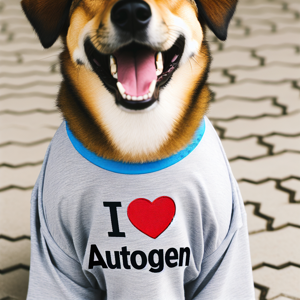

In [14]:
images = extract_images(dalle, critic)

for image in reversed(images):
    image = image.resize((300, 300))
    display(image)